# Document 2. Twitter Scraper using Selenium
 
## Aim 
> To quantify gender bias in science, technology, engineering and mathematics in language data and prototype a method to reduce this bias.

##  Rationale
> There is a gender imbalance in STEM careers (ref). In 2016, of the total Australian STEM qualified workforce, only 17% were women.  Women are particularly underrepresented in STEM-related academia (31%), IT (28%) and engineering (12.4%) (Australian Government, 2019). Because gender disparities are rooted in cultural norms, values and discourse (ref), it is expected that this imbalance in the should appear as bias in everyday language (ref). This bias may even be amplified in any predictions made based on language data (Sun et al. 2019). 

>Natural Language Processing (NLP) is the application of data science to language (ref). Language comprises some of the richest and most complex data, and can provide nuanced insights to virtually any topic, in terms of human thoughts and reactions to different phenomena (ref). Unsurprisingly, the rise of social media has provided an ideal source of language data. In 2020, 500 million tweets were published daily, providing a large number and extensive range of language data relating to any conceivable topic (ref). Social media platforms, such as Twitter, behave as largely uncensored, global-scale historical record from the perspective of everyday members of society, not just the powerful and privileged, as has been the case in the past (although, importantly, and in line with the topic of this report, Tweets written by people of colour are more likely to be flagged as offensive and removed by machine learning algorithms (Wei, 2020)).

>Because this investigation seeks to research implicit gender bias in STEM-related topics, and because gender bias is a social issue, it is sensible to look for data where people produce a high volume of text relating to, in this case, STEM careers. Users from around the world routinely post their uninhibited thoughts and feelings about all kinds of topics, and so Twitter can be treated as a repository of people’s opinions and attitudes, and therefore their personal biases, and on a grander scale, the biases of society, through time. This makes Twitter an ideal source of data for sentiment analysis (ref). 

>The ability of scraping data from Twitter, using specific search terms, allows targeted collection of information and ensures that the data collected are relevant to this investigation. For these reasons, Twitter is the sole website from which data were extracted.





In [35]:
# Import packages
import pandas as pd
import numpy as np
from getpass import getpass
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from webdriver_manager.chrome import ChromeDriverManager
import csv
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import xticks
from matplotlib.pyplot import yticks
import matplotlib.ticker as mtick
from matplotlib.ticker import StrMethodFormatter


## Methods

### Methodology
>For this analysis of STEM gender bias in language data, the methodology was as follows: 
* Scrape tweets about STEM, relating to people.
* Clean the data so it can be used in NLP tasks.
* Investigate the number of STEM tweets containing female pronouns vs male pronouns.
* Report findings from a preliminary exploration of these data.

> Although Twitter has an API which can be used for academic purposes, in line with the task requirements Selenium was used to simulate a search within a browser and data were collected using xpath().
> The search term was (science OR scientist OR technology OR technologist OR engineering OR engineer OR math OR mathematics OR mathematician) (she OR her OR he OR him) -filter: retweets.


### Webscraper
> The data from Twitter were complicated to extract – why?. Due to the perpetual scrolling nature of the site, it was decided that the best way to scrape Tweet data (other than using the API) would be using the Selenium package. Selenium works by automating web browser activity, replicating functions such as opening a browser, clicking on links and scrolling pages (ref). The package requires installation of a driver to interface with a browser (Chrome was used in thiscase). Selenium was used to open, navigate and enter a search term to scrape Tweet data while scrolling downwards, allowing new Tweets to appear. The xpath() function was used to select specific data from each Tweet. Username, handle, Tweet and the number of comments, retweets, likes and the post date were retrieved.

> After identifying issues with the running of the webscraper, modifications were made to the code to catch two types of exception: NoSuchElementException, which can occur when the scraper attempts to access an element before the page has fully loaded, and StaleElementReferenceException, which occurs when some element is temporarily inaccessible. Elements were identified and extracted using the HTML inspect navigation panel corresponding to the page in the Chrome browser.

> Once the scraper had collected all the data, the information was saved to a .csv file. The resulting dataset comprised over 34,000 records of STEM-related tweets from April 14, 2021 (the day of collection).


In [2]:
# Function to scrape Twitter using Selenium

def get_tweet_data(card):
    #Extract tweet data
    #username
    try:
        username = card.find_element_by_xpath('.//span').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #twitter handle
    try:
        handle = card.find_element_by_xpath('.//span[contains(text(), "@")]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #tweet text
    try:
        comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
        responding = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
        text = comment+responding
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #reply count
    try:
        comment = card.find_element_by_xpath('//div[@data-testid="reply"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #retweet count
    try:
        retweet = card.find_element_by_xpath('//div[@data-testid="retweet"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #likes
    try:
        like = card.find_element_by_xpath('//div[@data-testid="like"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    try:
        #post date
        date = card.find_element_by_xpath('.//time').get_attribute('datetime')
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    
    tweet = (username, handle, text, comment, retweet, like, date)
    return tweet 

# create instance of webdriver
driver = webdriver.Chrome()
driver.get('https://www.twitter.com/login')


In [3]:
#navigate to twitter and login
username = driver.find_element_by_xpath('//input[@name="session[username_or_email]"]')
username.send_keys('laura.vodden@outlook.com')
mypassword = getpass()

password = driver.find_element_by_xpath('//input[@name="session[password]"]')
password.send_keys(mypassword)
password.send_keys(Keys.RETURN)


········


In [5]:
#find search input and search for term

#navigte to 'explore' tab
driver.find_element_by_xpath('//a[@data-testid="AppTabBar_Explore_Link"]').click()

search_input = driver.find_element_by_xpath('//input[@aria-label="Search query"]')
search_input.send_keys('(science OR technology OR engineering OR math OR mathematics OR scientist OR technologist OR engineer OR mathematician) (she OR her OR he OR him) -filter:retweets')
search_input.send_keys(Keys.RETURN)

#navigte to 'latest' tab
driver.find_element_by_link_text('Latest').click()

# get all tweets on the page
data = []
tweet_ids = set()
last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_cards = driver.find_elements_by_xpath('//div[@data-testid="tweet"]')
    for card in page_cards[-15:]:
        tweet = get_tweet_data(card)
        if tweet:
            tweet_id = ''.join(tweet)
            if tweet_id not in tweet_ids:
                tweet_ids.add(tweet_id)
            data.append(tweet)
    
    scroll_attempt = 0
    while True:
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(1)
        curr_position = driver.execute_script("return window.pageYOffset;")
        if last_position == curr_position:
            scroll_attempt += 1
            
            #end of scroll region
            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(2) # attempt to scroll again
        else:
            last_position = curr_position
            break

#save tweet data
with open('stem_tweets_2.csv', 'w', newline='', encoding='utf-8') as f:
    header = ['Username', 'Handle', 'Text', 'Comments', 'Retweets', 'Likes', 'Date']
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)

### View the scraped data
> Tweets containing the specified search terms were extracted straight into several columns: Tweet, STEM hashtags, gender pronouns. From here, information was extracted from Tweets. 
> The resulting dataframe comprised over 34,000 records of STEM-related tweets from April 14, 2021 (the day of collection).


In [70]:
# Ipmort data and view dataframe head
tweets_df = pd.read_csv("stem_tweets.csv", dtype=object)
tweets_df = tweets_df.fillna(0)
tweets_df.head(10)

,Username,Handle,Text,Comments,Retweets,Likes,Date
0,Angi,@AngiMaryssa,"Blackwell is great. As a lawyer, you have to b...",0,0,0,2021-04-14T20:32:29.000Z
1,Señor Luis (1LUV),@thiccbb69,"math dumb af, if y=mx+b then y=tf don't she lo...",0,0,0,2021-04-14T20:32:24.000Z
2,Jared Halpern,@JaredEHalpern,"Wow, he was a hell of an engineer --Grant Imah...",0,0,0,2021-04-14T20:32:23.000Z
3,Bob Brigham,@BobBrigham,Matt Kelley is so bad he thinks coronavirus is...,0,0,0,2021-04-14T20:32:10.000Z
4,AlaskanTzar,@AlaskanTzar,Replying to \n@science_bradyBut he was?,0,0,0,2021-04-14T20:31:58.000Z
5,word vomit (erika),@vomit_bestie,that math test i just took was my absolute bit...,0,0,0,2021-04-14T20:31:55.000Z
6,Thomas Howard Riley MAD SCIENTIST of EPIC FANTASY,@ornithopteryx,Replying to \n@R_M__AndrewsOMG that is so funn...,0,0,0,2021-04-14T20:31:43.000Z
7,m d ryan,@hawkdynasty526,Replying to \n@Mhal2005\n and \n@Kr8ckenyou’re...,0,0,0,2021-04-14T20:31:40.000Z
8,Stephen,@Steve_ForChange,Replying to \n@716babe\n @StephieKonicki\n and...,0,0,0,2021-04-14T20:31:33.000Z
9,catlady,@suchmeerkat,Replying to \n@shaTIRED5th grade he had everyo...,0,0,0,2021-04-14T20:31:18.000Z


##     
## Data processing
### Data cleaning 
> There were several necessary steps involved in preparing the Tweet data for analysis using NLP methods. First, user handles were removed using a lambda function targeting the @ symbol before user handles. After this, the remaining punctuation was removed. 
> Furthermore, a new column was generated with values ‘M’ or ‘F’, corresponding to male or female, depending on which pronouns were present in the original Tweet.
> The resulting dataframe contained 17,313 rows, with four columns containing the User Handle, the text of each Tweet, the tokenised and Lemmatised Tweet and Gender data.
> The dataframe was saved as a .csv file for later use.



In [71]:
# Remove handles
tweets_df['Text'] =  tweets_df['Text'].apply(lambda x: re.sub('@[\w]+','', str(x)))

#Remove punctuation
# remove 's, 'll, 'd  
tweets_df['Text'] = tweets_df['Text'].str.replace("'s","")
tweets_df['Text'] = tweets_df['Text'].str.replace("'ll","")
tweets_df['Text'] = tweets_df['Text'].str.replace("'d","")
tweets_df['Text'] = tweets_df['Text'].str.replace("Replying to ","")
tweets_df['Text'] = tweets_df['Text'].str.replace("\n","")
 

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

tweets_df['Text']=tweets_df['Text'].apply(lambda x: remove_punctuation(x))


# Assign a gender to each tweet based on pronouns present
tweets_df.loc[tweets_df['Text'].str.contains(' he '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains('He '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains(' him '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains(' she '), 'Gender'] = 'F'
tweets_df.loc[tweets_df['Text'].str.contains('She'), 'Gender'] = 'F'
tweets_df.loc[tweets_df['Text'].str.contains(' her '), 'Gender'] = 'F'

# Assign a topic to each tweet based on topic in text
tweets_df.loc[tweets_df['Text'].str.contains('science'), 'Topic'] = 'science'
tweets_df.loc[tweets_df['Text'].str.contains('scientist'), 'Topic'] = 'science'
tweets_df.loc[tweets_df['Text'].str.contains('technology '), 'Topic'] = 'technology'
tweets_df.loc[tweets_df['Text'].str.contains('technogist'), 'Topic'] = 'technology'
tweets_df.loc[tweets_df['Text'].str.contains('engineering'), 'Topic'] = 'engineering'
tweets_df.loc[tweets_df['Text'].str.contains('engineer'), 'Topic'] = 'engineering'
tweets_df.loc[tweets_df['Text'].str.contains('math'), 'Topic'] = 'mathematics'
tweets_df.loc[tweets_df['Text'].str.contains('mathematics'), 'Topic'] = 'mathematics'
tweets_df.loc[tweets_df['Text'].str.contains('mathematician'), 'Topic'] = 'mathematics'


tweets_df = tweets_df[["Handle", "Text", "Likes", "Gender", "Topic"]]


# Drop any rows containing blanks
tweets_df = tweets_df.replace(r'^\s*$', np.nan, regex=True)
tweets_df = tweets_df.dropna()

# Shuffle data
tweets_df = tweets_df.sample(frac=1).reset_index(drop=True)

tweets_df.head()

,Handle,Text,Likes,Gender,Topic
0,@Rick_Crainium,and 17 othersSorry to interrupt he Good Morn...,3.6K,M,science
1,@keithebae,Seongmin didnt attend a tutoring academy but h...,1,M,mathematics
2,@JaredLesterSmi1,and 2 othersMaybe it a lack of science educa...,0,M,science
3,@Elonnieee,I’m so glad my bf is smartso he can do my math...,2,M,mathematics
4,@MainNashville,Meet Gena Johnson who has worked with John Pri...,0,F,engineering


In [72]:
len(tweets_df)

17313

In [73]:
# Save to csv
tweets_df.to_csv ('tweets_df.csv', index = None, header=True)

##       
## Preliminary data exploration

### All STEM Tweets by gender
> Preliminary analysis of the scraped data show, as expected, a strong bias in gender. In general, there are twice as many Tweets about men in relation to STEM as there are about women( 66.5% and 33.5%, respectively). In terms of gender, the dataset is unbalanced, which has implications for NLP tasks like classification.

Count of STEM Tweets by gender
M    11514
F     5799
Name: Gender, dtype: int64

Total Tweets: 17313
Percentage of STEM Tweets by gender
M    0.665049
F    0.334951
Name: Gender, dtype: float64



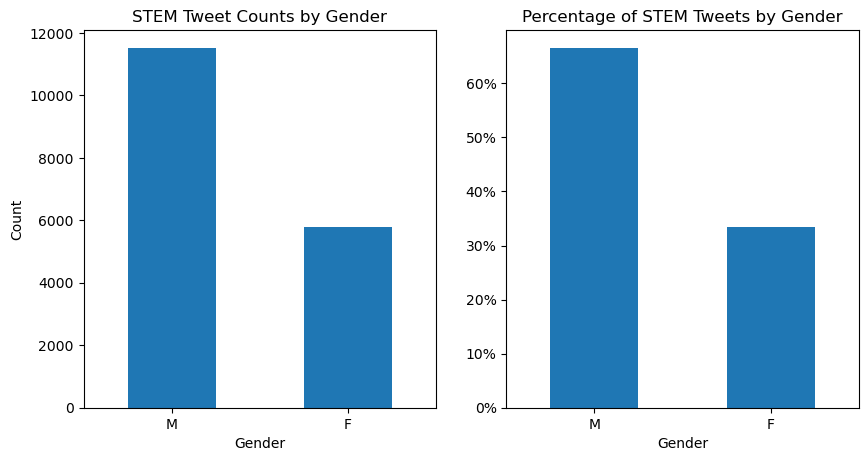

In [109]:
# Import data
tweets_df = pd.read_csv("tweets_df.csv", dtype=object)

# Count tweets about women vs men
print("Count of STEM Tweets by gender")
counts = tweets_df['Gender'].value_counts()
print(counts)
print()
print("Total Tweets:", len(tweets_df))

print("Percentage of STEM Tweets by gender")
prop = tweets_df['Gender'].value_counts(normalize=True)
print(prop)
print()

figure(figsize=(10, 5), dpi=100)
plt.subplot(1, 2, 1)
counts.plot(kind = 'bar')
plt.title('STEM Tweet Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
xticks(rotation=0)

plt.subplot(1, 2, 2)
prop.plot(kind = 'bar')
plt.title('Percentage of STEM Tweets by Gender')
plt.xlabel('Gender')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
xticks(rotation=0)
plt.show()

### Tweet topic by subject gender
> This trend is reflected within each of the STEM topics individually. The greatest discrepancy in men and women is shown in engineering, where female pronouns accompany less than 30% of all engineering Tweets. The smallest discrepancy is in mathematics, with female pronouns appearing in 39% of all Tweets about mathematics. 

> It is shown below that the vast majority of Tweets are on the topic of science in general, comprising almost 9,000 of the total 17,000 Tweets.

Count of STEM Tweets by gender
M    11514
F     5799
Name: Gender, dtype: int64



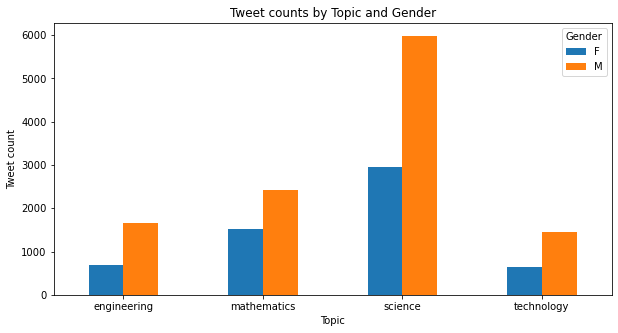

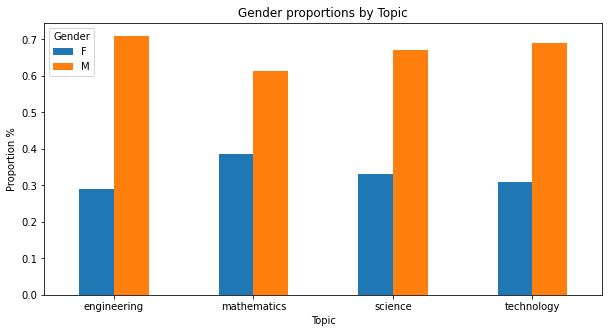

In [123]:
print("Count of STEM Tweets by gender")
#counts = tweets_df['Gender'].
print(counts)
print()

gender_counts = tweets_df.groupby(['Topic', 'Gender']).Gender.count().unstack()
gender_prop = tweets_df.groupby(['Topic', 'Gender']).size().groupby('Topic').transform(lambda x: x/x.sum()).unstack()




gender_counts.plot(kind='bar')
plt.title('Tweet counts by Topic and Gender')
plt.xlabel('Topic')
plt.ylabel('Tweet count')
plt.xticks(rotation = 0)


gender_prop.plot(kind = 'bar' )
plt.title('Gender proportions by Topic')
plt.ylabel('Proportion %')
xticks(rotation=0)

plt.rcParams["figure.figsize"] = (15,5)

plt.show()

## Website/data copyright considerations
> Even though Tweets are protected under copyright, this is an academic exercise and, as such, scraping Tweet data from Twitter does not violate copyright laws.
